<a href="https://colab.research.google.com/github/abhiWriteCode/Pong/blob/master/notebook_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install dependencies
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay matplotlib scikit-video > /dev/null 2>&1
!pip install gym[atari] 2>&1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import time
import utils


torch.manual_seed(0) # set random seed

torch.__version__

'1.2.0'

In [2]:
env = gym.make("Pong-v0")
env.seed(1) # reproducible, since RL has high variance

[1, 289714752]

In [3]:
print ("Enviornment has observation space = {}".format(env.observation_space))

Enviornment has observation space = Box(210, 160, 3)


In [4]:
n_actions = env.action_space.n
print ("Number of possible actions that the agent can choose from = {}".format(n_actions))

Number of possible actions that the agent can choose from = 6


In [0]:
def create_model():
    model = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=(7, 7), stride=(4, 4), padding=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(16, 32, kernel_size=(7, 7), stride=(2, 2), padding=3),
        nn.ReLU(inplace=True),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, n_actions),
        nn.Softmax(dim=1)
    )
    return model

In [0]:
def choose_action(model, state, eval=False):
    
    state = torch.from_numpy(state.reshape(1, 1, 80, 80)).float().to(device)
    probs = model(state).cpu()

    if eval:
        action = probs.argmax()
        return action.item()

    m = Categorical(probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

In [0]:
def normalize(x):
    x -= np.mean(x)
    x /= np.std(x)
    return x

def discount_rewards(rewards, gamma=0.99): 
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))):
        # NEW: Reset sum
        if rewards[t] != 0:
            R = 0
        # update the total discounted reward as before
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R
        
    return normalize(discounted_rewards)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
def pre_process(image):
    I = image[35:195] # Crop
    I = I[::2, ::2, 0] # Downsample width and height by a factor of 2
    I[I == 144] = 0 # Remove background type 1
    I[I == 109] = 0 # Remove background type 2
    I[I != 0] = 1 # Set remaining elements (paddles, ball, etc.) to 1
    return I.astype(np.float).ravel()

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


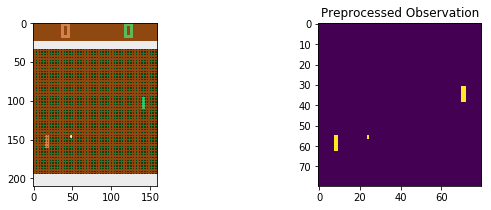

In [9]:
observation = env.reset()
for i in range(30):
    observation, _,_,_ = env.step(0)
observation_pp = pre_process(observation)

f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(observation); ax.grid('off');
ax2.imshow(observation_pp.reshape((80,80))); ax2.grid('off'); plt.title('Preprocessed Observation')
plt.show()

In [0]:
def reinforce(model, optimizer, n_episodes=10000, gamma=0.99):
    scores = []
    
    smoothed_reward = utils.LossHistory(smoothing_factor=0.5)
    plotter = utils.PeriodicPlotter(sec=10, xlabel='Iterations', ylabel='Rewards')

    for i_episode in range(1, n_episodes + 1):
        saved_log_probs = []
        rewards = []

        # Restart the environment
        observation = env.reset()
        previous_frame = pre_process(observation)
        done = False
        while not done:
            current_frame = pre_process(observation)
            obs_change = current_frame - previous_frame
            action, log_prob = choose_action(model, obs_change)
            next_observation, reward, done, _ = env.step(action)
                
            observation = next_observation
            previous_frame = current_frame

            saved_log_probs.append(log_prob)
            rewards.append(reward)
                
        total_reward = sum(rewards)
        scores.append( total_reward )
        smoothed_reward.append( total_reward )

        R = discount_rewards(rewards, gamma=gamma)
        R = torch.from_numpy(R)

        policy_loss = []
        for log_prob, r in zip(saved_log_probs, R):
            policy_loss.append(-log_prob * r)
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        plotter.plot(smoothed_reward.get())
        # print(f'Avg Reward : {np.mean(scores):.4f} | Current Reward : {total_reward:.4f}')

In [21]:
pong = create_model().to(device)
optimizer = torch.optim.Adam(pong.parameters(), lr=1e-2)

pong

Sequential(
  (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  (1): ReLU(inplace=True)
  (2): Conv2d(16, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (3): ReLU(inplace=True)
  (4): Flatten()
  (5): Linear(in_features=3200, out_features=256, bias=True)
  (6): ReLU(inplace=True)
  (7): Linear(in_features=256, out_features=6, bias=True)
  (8): Softmax(dim=1)
)

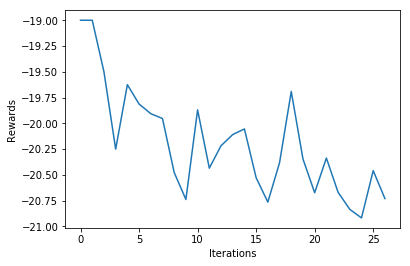

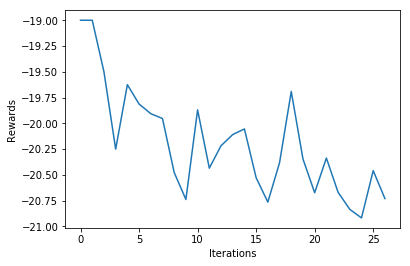

In [26]:
try:
    reinforce(pong, optimizer, n_episodes=10000)
except KeyboardInterrupt:
    pass

In [0]:
checkpoint = 'checkpoint.pt'
torch.save(pong.state_dict(), checkpoint)

In [40]:
# Evaluation Model

pong_eval = create_model().to(device)
pong_eval.load_state_dict(torch.load(checkpoint))
pong_eval.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  (1): ReLU(inplace=True)
  (2): Conv2d(16, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (3): ReLU(inplace=True)
  (4): Flatten()
  (5): Linear(in_features=3200, out_features=256, bias=True)
  (6): ReLU(inplace=True)
  (7): Linear(in_features=256, out_features=6, bias=True)
  (8): Softmax(dim=1)
)

In [42]:
def save_video_of_model(model, env_name, filename='agent.mp4'):  
    import skvideo.io
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(40, 30))
    display.start()

    env = gym.make(env_name)
    obs = env.reset()
    shape = env.render(mode='rgb_array').shape[0:2]

    out = skvideo.io.FFmpegWriter(filename)

    previous_frame = pre_process(obs)
    done = False
    
    model.eval()
    with torch.no_grad():
        while not done: 
            frame = env.render(mode='rgb_array')
            out.writeFrame(frame)

            current_frame = pre_process(obs)

            obs_change = current_frame - previous_frame 

            action = choose_action(model, obs_change, eval=True)
            
            obs, reward, done, info = env.step(action)
            previous_frame = current_frame
    out.close()
    print ("Successfully saved into {}!".format(filename))

save_video_of_model(pong_eval, "Pong-v0", filename='pong_agent.mp4')

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


Successfully saved into pong_agent.mp4!


In [0]:
from IPython.display import HTML
import io, base64
video = io.open('./pong_agent.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))